In [1]:
#libraries
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
#download the classifier
IMAGE_SHAPE=(224,224)
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier=tf.keras.Sequential([
                                hub.KerasLayer(classifier_model,input_shape=IMAGE_SHAPE+(3,))
                                ])

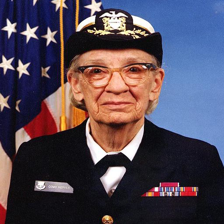

In [3]:
#download a single image to try the model on
grace_hopper=tf.keras.utils.get_file('image.jpg','https://media.wired.com/photos/5cdefb92b86e041493d389df/125:94/w_1265,h_951,c_limit/Culture-Grumpy-Cat-487386121.jpg')
grace_hopper=Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [4]:
grace_hopper=np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [5]:
#add a vatch dimension and pass the image to the model
result=classifier.predict(grace_hopper[np.newaxis,...])
result.shape

(1, 1001)

In [6]:
predicted_class=np.argmax(result[0],axis=-1)
predicted_class

653

In [7]:
#decode the prediction
labels_path=tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels=np.array(open(labels_path).read().splitlines())

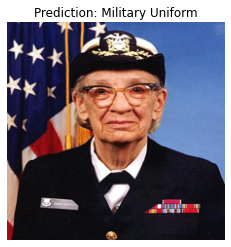

In [8]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name=imagenet_labels[predicted_class]
_=plt.title("Prediction: "+predicted_class_name.title())

In [10]:
#SIMPLE TRANSFER LEARNING
data_root=tf.keras.utils.get_file(
    'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',untar=True
)

228818944/228813984 [==============================] - 2s 0us/step


In [11]:
#load this data into our model using images off disk using image_dataset_from_directory
batch_size=32
img_height=224
img_width=224

train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    str(data_root),
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
class_names=np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [13]:
#scale
normalization_layer=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds=train_ds.map(lambda x,y: (normalization_layer(x),y))

In [15]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [16]:
#run the classifier on a batch of images
result_batch=classifier.predict(train_ds)
predicted_class_names=imagenet_labels[np.argmax(result_batch,axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

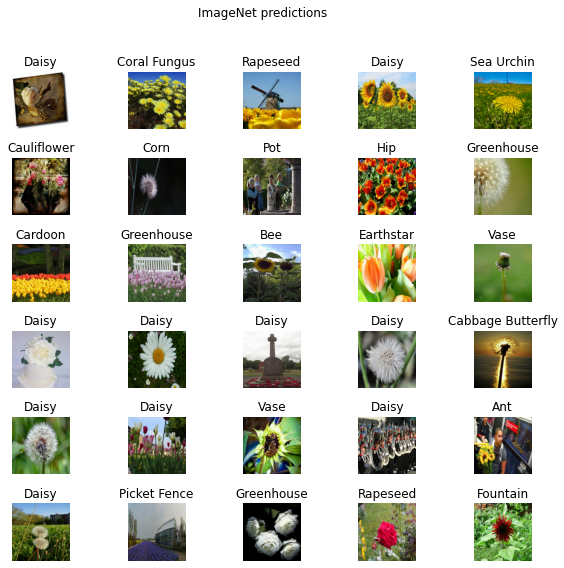

In [41]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n].title())
  plt.axis('off')
  _=plt.suptitle('ImageNet predictions')

In [24]:
#download the headless model
#tf hub also distributes models without the top classification layer,these can be used to easily do transfer learning

feature_extractor_model="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer=hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224,224,3),
    trainable=False
)
feature_batch=feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [25]:
#Attach a classification head
num_classes=len(class_names)
model=tf.keras.Sequential([
                           feature_extractor_layer,
                           tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
predictions=model(image_batch)
predictions.shape

TensorShape([32, 5])

In [27]:
#Train the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [32]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses=[]
    self.batch_acc=[]
  
  def on_train_batch_end(self,batch,logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback=CollectBatchStats()

history=model.fit(train_ds,epochs=2,callbacks=[batch_stats_callback])

Epoch 1/2
92/92 [==============================] - 110s 1s/step - loss: 0.7379 - acc: 0.7348
Epoch 2/2
92/92 [==============================] - 105s 1s/step - loss: 0.3690 - acc: 0.8780


Text(0.5, 1.0, 'LOSS')

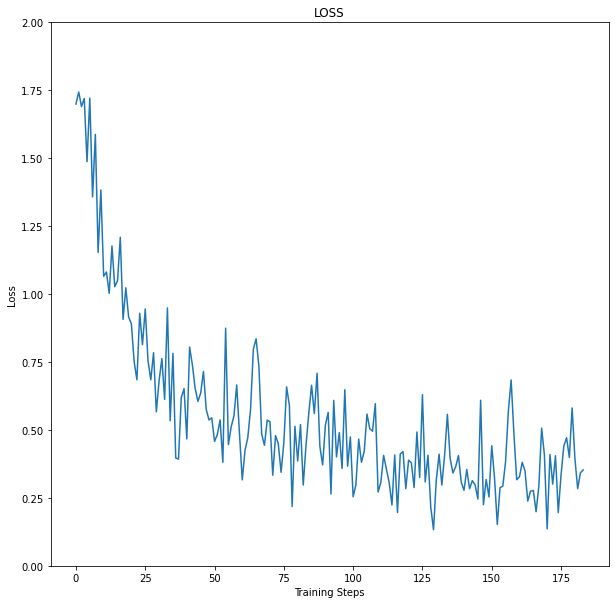

In [37]:
plt.figure(figsize=(10,10))
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.title('LOSS')

Text(0.5, 1.0, 'ACCURACY')

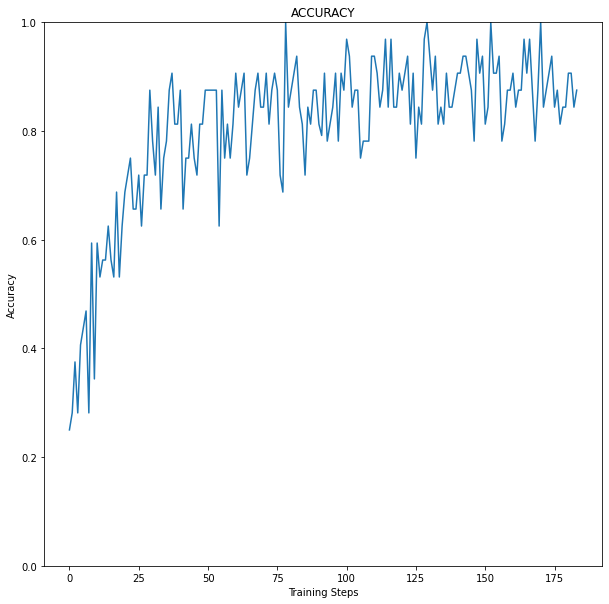

In [38]:
plt.figure(figsize=(10,10))
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.title('ACCURACY')

In [39]:
#check the predictions
predicted_batch=model.predict(image_batch)
predicted_id=np.argmax(predicted_batch,axis=-1)
predicted_label_batch=class_names[predicted_id]

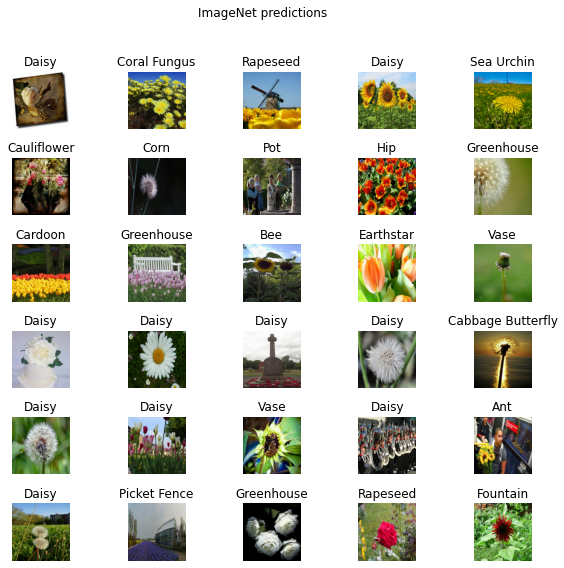

In [47]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n].title())
  plt.axis('off')
  _=plt.suptitle('ImageNet predictions')

In [43]:
#export the model
t=time.time()
export_path="/tmp/saved_models/{}".format(int(t))
model.save(export_path)
export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1619525602/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1619525602/assets


'/tmp/saved_models/1619525602'

In [45]:
reloaded=tf.keras.models.load_model(export_path)

In [46]:
result_batch=model.predict(image_batch)
reloaded_result_batch=reloaded.predict(image_batch)
abs(reloaded_result_batch-result_batch).max()

0.0